# 简易的北京市地铁导航图

In [1]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# 读取数据
subway_df = pd.read_table('subway', sep=',')

In [3]:
subway_df.head()

,line,station,dimension,longitude,time
0,1号线,苹果园,116.411707,39.983603,00:00
1,1号线,古城,116.197072,39.913414,04:58
2,1号线,八角游乐园,116.219390,39.913076,05:01
3,1号线,八宝山,116.242277,39.913185,05:04
4,1号线,玉泉路,116.259470,39.913501,05:06


In [4]:
# 查看地铁有多少号线
def get_subway_lines(subway_df):
    return subway_df['line'].drop_duplicates().tolist()

In [5]:
print(get_subway_lines(subway_df))

['1号线', '2号线', '4号线', '5号线', '6号线', '7号线', '8号线北', '8号线南', '9号线', '10号线', '13号线', '14号线西', '14号线东', '15号线', '16号线', '八通线', '昌平线', '亦庄线', '房山线', '机场线', 'S1线', '燕房线', '西郊线']


In [6]:
# 封装地铁路线和路线站点数据结构（例如：k=1号线, v=[苹果园,古城,...]）
def get_subway_lines_dict(subway_df):
    subway_lines_dict = {}
    for line in get_subway_lines(subway_df):
        subway_lines_dict[line] = subway_df[subway_df['line'] == line]['station'].tolist()
    return subway_lines_dict

In [7]:
# print(get_subway_lines_dict(subway_df))

In [8]:
# 获取每个站点的位置，即经纬度（例如：k=苹果园, v=[经度, 纬度]）
def get_station_position(subway_df):
    station_position = {}
    subway_data = subway_df.values
    for i in range(len(subway_data)):
        station_position[subway_data[i, 1]] = [subway_data[i, 2], subway_data[i, 3]]
    return station_position

In [9]:
# print(get_station_position(subway_df))

In [10]:
# 构造每一个站点连接的下一站之间的关系
def get_connection_station(subway_df):
    connection_station = {}
    for per_line in get_subway_lines(subway_df):
        line_stations = subway_df[subway_df['line'] == per_line]['station'].tolist()
        for i in range(len(line_stations)):
            per_station = line_stations[i]
            next_stations = []
            if per_station in connection_station.keys():
                next_stations = connection_station[per_station]
            if i - 1 > -1 and line_stations[i - 1] not in next_stations:
                next_stations.append(line_stations[i - 1])
            if i + 1 < len(line_stations) and line_stations[i + 1] not in next_stations:
                next_stations.append(line_stations[i + 1])
            # 但是10号线有点特殊，是环形线，没有终点站之分。所以要对10号线作特殊处理            
            if per_line == '10号线' and per_station == '巴沟': next_stations.append('火器营')
            if per_line == '10号线' and per_station == '火器营': next_stations.append('巴沟')
            connection_station[per_station] = next_stations
    return connection_station

In [11]:
# print(get_connection_station(subway_df))

In [12]:
%matplotlib inline

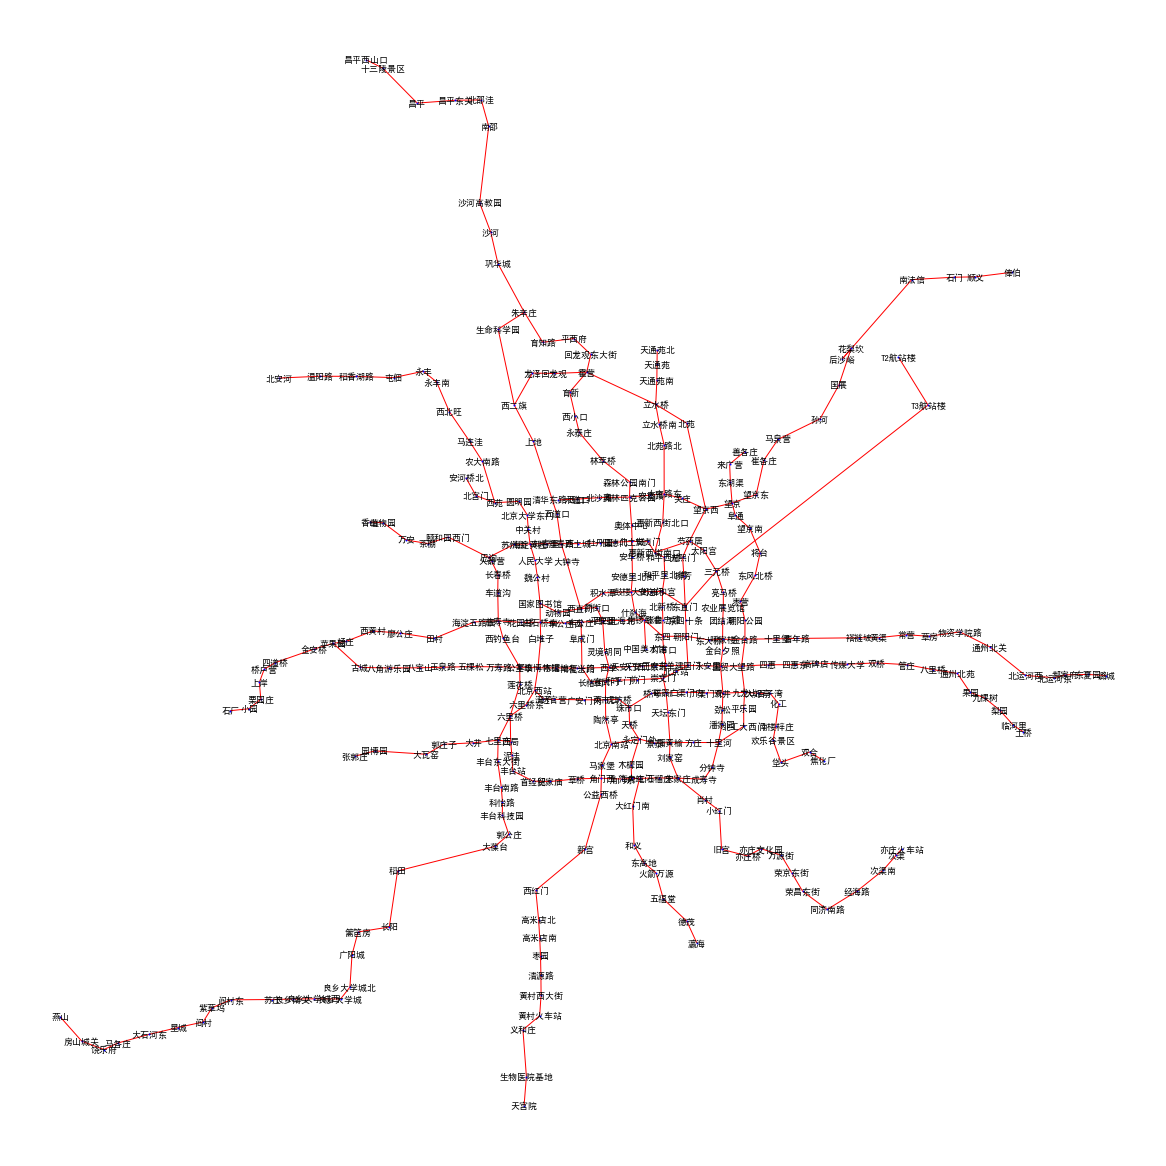

In [13]:
# 画出地铁站之间的关系图
G = nx.random_graphs.barabasi_albert_graph(1000, 100)
plt.figure(figsize=(16, 16))
nx.draw(nx.Graph(get_connection_station(subway_df)), get_station_position(subway_df), with_labels=True, node_size=1, 
        node_color = 'b',edge_color = 'r',font_size =9)

In [14]:
# 计算两地之间的距离
def calculate_distance(address_start, address_end):
    station_dict = get_station_position(subway_df)
    dimension_start, longitude_start = station_dict[address_start]
    dimension_end, longitude_end = station_dict[address_end]
    radius = 6371  # km
    dimension_d = math.radians(dimension_end - dimension_start)
    longitude_d = math.radians(longitude_end - longitude_start)
    val_a = (math.sin(dimension_d / 2) * math.sin(dimension_d / 2) +
         math.cos(math.radians(dimension_start)) * math.cos(math.radians(dimension_end)) *
         math.sin(longitude_d / 2) * math.sin(longitude_d / 2))
    return radius * 2 * math.atan2(math.sqrt(val_a), math.sqrt(1 - val_a))

# 查找经过的地铁路线包括了那几号线
def search_lines_by_stations(stations):
    subway_lines = []
    temp = ''
    if len(stations) < 2: return subway_lines
    for i in range(1, len(stations)):
        line = get_connection_line(stations[i-1], stations[i])
        if line and line != temp:
            subway_lines.append(line)
        temp = line
    return subway_lines

# 查找两个地铁站之间的地铁路线是几号线
def get_connection_line(station_1, station_2):
    lines_1 = subway_df[subway_df['station'] == station_1]['line'].tolist()
    lines_2 = subway_df[subway_df['station'] == station_2]['line'].tolist()
    for per_line in lines_2:
        if per_line in lines_1:
            # print(per_line, station_2)
            return per_line
    return None

# 打印路径
def print_path_info(stations, paths):
    print('经过站点：\n[{}]'.format(' > 🚈> '.join(stations)))
    print('总站数：{}站'.format(len(stations)))
    print('乘坐路线：[{}]'.format(' > 🚈> '.join(paths)))

## a.路程最短算法

In [15]:
def search_short_distance_path(start_station, end_station):
    # 处理下面在获取不存在key时异常问题
    connection_station = defaultdict(list)
    connection_station.update(get_connection_station(subway_df))
    paths = [[start_station]]
    visited_stations = set()
    # 保存到达每个站点的路程最短路径，key为station，value为以key站点结尾的最短path
    short_paths_dict = {}
    short_paths = defaultdict(list)
    short_paths.update(short_paths_dict)
    while paths:
        path = paths.pop(0)
        last_station = path[-1]
        stations = connection_station[last_station]
        for next_station in stations:
            if next_station in visited_stations: continue
            new_path = path + [next_station]
            if short_paths[next_station]:
                old = get_distance(short_paths[next_station])
                new = get_distance(new_path)
                if new < old: short_paths[next_station] = new_path
            else:
                short_paths[next_station] = new_path
            paths.append(new_path)
        visited_stations.add(last_station)
        # 升序排序
        paths = sorted_by_distance(paths)
    return short_paths[end_station]

# 计算 path 的长度
def get_distance(path):
    distance = 0
    for i in range(1, len(path)):
        distance += calculate_distance(path[i - 1], path[i])
    return distance
        
# 根据距离最短排序      
def sorted_by_distance(paths):
    if len(paths) < 2: return paths
    # sorted 函数默认是升序
    return sorted(paths, key=get_distance)

In [16]:
%%time
pass_stations = search_short_distance_path('经海路', '北安河')

CPU times: user 4min 6s, sys: 695 ms, total: 4min 7s
Wall time: 4min 8s


In [17]:
pass_paths = search_lines_by_stations(pass_stations)

In [18]:
print_path_info(pass_stations, pass_paths)

经过站点：
[经海路 > 🚈> 同济南路 > 🚈> 荣昌东街 > 🚈> 荣京东街 > 🚈> 万源街 > 🚈> 亦庄文化园 > 🚈> 亦庄桥 > 🚈> 旧宫 > 🚈> 小红门 > 🚈> 肖村 > 🚈> 宋家庄 > 🚈> 刘家窑 > 🚈> 蒲黄榆 > 🚈> 天坛东门 > 🚈> 磁器口 > 🚈> 崇文门 > 🚈> 东单 > 🚈> 灯市口 > 🚈> 东四 > 🚈> 南锣鼓巷 > 🚈> 北海北 > 🚈> 平安里 > 🚈> 新街口 > 🚈> 西直门 > 🚈> 大钟寺 > 🚈> 知春路 > 🚈> 知春里 > 🚈> 海淀黄庄 > 🚈> 中关村 > 🚈> 北京大学东门 > 🚈> 圆明园 > 🚈> 西苑 > 🚈> 农大南路 > 🚈> 马连洼 > 🚈> 西北旺 > 🚈> 永丰南 > 🚈> 永丰 > 🚈> 屯佃 > 🚈> 稻香湖路 > 🚈> 温阳路 > 🚈> 北安河]
总站数：41站
乘坐路线：[亦庄线 > 🚈> 5号线 > 🚈> 6号线 > 🚈> 4号线 > 🚈> 13号线 > 🚈> 10号线 > 🚈> 4号线 > 🚈> 16号线]


## b.乘坐站点最少

In [19]:
# 乘坐站点最少的路线
def search_minor_station_path(start_station, end_station, subway_df):
    # 处理下面在获取不存在key时异常问题
    connection_station = defaultdict(list)
    connection_station.update(get_connection_station(subway_df))
    paths = [[start_station]]
    visited_station = set()
    while paths:
        path = paths.pop(0)
        last_station = path[-1]
        stations = connection_station[last_station]
        for station in stations:
            if station in visited_station: continue
            if station == end_station: return path + [station]
            paths.append(path + [station])
        visited_station.add(last_station)
        # 根据长度排序
        paths = sorted(paths, key=len)

In [20]:
%%time
# 测试  
pass_stations = search_minor_station_path('经海路', '北安河', subway_df)

CPU times: user 26.2 ms, sys: 778 µs, total: 27 ms
Wall time: 26.5 ms


In [21]:
pass_paths = search_lines_by_stations(pass_stations)

In [22]:
print_path_info(pass_stations, pass_paths)

经过站点：
[经海路 > 🚈> 同济南路 > 🚈> 荣昌东街 > 🚈> 荣京东街 > 🚈> 万源街 > 🚈> 亦庄文化园 > 🚈> 亦庄桥 > 🚈> 旧宫 > 🚈> 小红门 > 🚈> 肖村 > 🚈> 宋家庄 > 🚈> 刘家窑 > 🚈> 蒲黄榆 > 🚈> 天坛东门 > 🚈> 磁器口 > 🚈> 崇文门 > 🚈> 东单 > 🚈> 灯市口 > 🚈> 东四 > 🚈> 南锣鼓巷 > 🚈> 北海北 > 🚈> 平安里 > 🚈> 新街口 > 🚈> 西直门 > 🚈> 大钟寺 > 🚈> 知春路 > 🚈> 知春里 > 🚈> 海淀黄庄 > 🚈> 中关村 > 🚈> 北京大学东门 > 🚈> 圆明园 > 🚈> 西苑 > 🚈> 农大南路 > 🚈> 马连洼 > 🚈> 西北旺 > 🚈> 永丰南 > 🚈> 永丰 > 🚈> 屯佃 > 🚈> 稻香湖路 > 🚈> 温阳路 > 🚈> 北安河]
总站数：41站
乘坐路线：[亦庄线 > 🚈> 5号线 > 🚈> 6号线 > 🚈> 4号线 > 🚈> 13号线 > 🚈> 10号线 > 🚈> 4号线 > 🚈> 16号线]


## c.换乘路线最少

In [23]:
# 构建地铁换乘路线图：
def subway_lines_map(subway_df):
    subway_lines_dict = {}
    subway_lines = defaultdict(list)
    subway_lines.update(subway_lines_dict)
    all_stations = subway_df['station'].drop_duplicates().tolist()
    for station in all_stations:
        lines = subway_df[subway_df['station'] == station]['line'].tolist()
        if len(lines) > 1:
            for i in range(len(lines)):
                if lines[i] not in subway_lines.keys():
                    subway_lines[lines[i]] = lines[:i] + lines[i+1:]
                else:
                    s = set(subway_lines[lines[i]] + lines[:i] + lines[i+1:])
                    subway_lines[lines[i]] = list(s)
    return subway_lines

In [24]:
connection_subway_lines = subway_lines_map(subway_df)

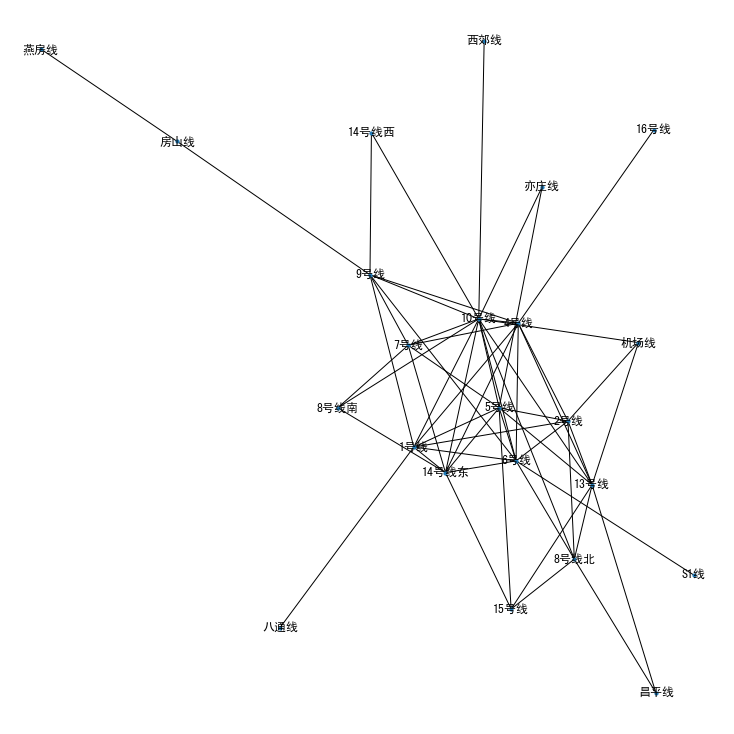

In [25]:
# 画出地铁站之间的关系图
G = nx.random_graphs.barabasi_albert_graph(100, 10)
plt.figure(figsize=(10, 10))
nx.draw(nx.Graph(connection_subway_lines), with_labels=True, node_size=10)

In [26]:
print(connection_subway_lines)

defaultdict(<class 'list'>, {'1号线': ['4号线', '14号线东', '10号线', '八通线', '2号线', '9号线', '6号线', '5号线'], '6号线': ['1号线', '4号线', '14号线东', 'S1线', '2号线', '9号线', '10号线', '5号线', '8号线北'], '10号线': ['8号线南', '机场线', '1号线', '13号线', '14号线西', '7号线', '4号线', '14号线东', '西郊线', '9号线', '5号线', '6号线', '亦庄线', '8号线北'], '9号线': ['房山线', '1号线', '14号线西', '7号线', '4号线', '10号线', '6号线'], '2号线': ['机场线', '1号线', '13号线', '4号线', '6号线', '5号线', '8号线北'], '4号线': ['1号线', '13号线', '16号线', '7号线', '14号线东', '10号线', '2号线', '9号线', '6号线'], '5号线': ['1号线', '13号线', '7号线', '15号线', '14号线东', '10号线', '2号线', '6号线', '亦庄线'], '14号线东': ['8号线南', '1号线', '6号线', '7号线', '4号线', '15号线', '10号线', '5号线'], '八通线': ['1号线'], '13号线': ['机场线', '昌平线', '4号线', '15号线', '2号线', '10号线', '5号线', '8号线北'], '8号线北': ['13号线', '昌平线', '15号线', '10号线', '2号线', '6号线'], '机场线': ['2号线', '10号线', '13号线'], '7号线': ['8号线南', '4号线', '14号线东', '9号线', '10号线', '5号线'], '16号线': ['4号线'], '亦庄线': ['5号线', '10号线'], '15号线': ['14号线东', '5号线', '13号线', '8号线北'], 'S1线': ['6号线'], '8号线南': ['7号线', '14号线东', '10号线'], '昌平线': 

In [27]:
# 换乘地铁路线最少
def search_minor_line_path(start_station, end_station):
    line_means = []
    start_lines = subway_df[subway_df['station'] == start_station]['line'].tolist()
    end_lines = subway_df[subway_df['station'] == end_station]['line'].tolist()
    line_means = [search_minor_lines(s_line, e_line) for s_line in start_lines for e_line in end_lines]
    line_means = sorted(line_means, key=len)
    lines = line_means[0]
    return lines

# 线路直接换乘最少路线
def search_minor_lines(start_line, end_line):
    # 处理下面在获取不存在key时异常问题
    connection_line = defaultdict(list)
    connection_line.update(connection_subway_lines)
    paths = [[start_line]]
    visited_lines = set()
    while paths:
        path = paths.pop(0)
        last_line = path[-1]
        lines = connection_line[last_line]
        for line in lines:
            if line in visited_lines: continue
            if line == end_line: return path + [line]
            paths.append(path + [line])
        visited_lines.add(last_line)
        # 根据长度排序
        paths = sorted(paths, key=len)

# 根据换乘的路线计算经过的站点
def get_stations_by_lines(start_station, end_station, lines):
    stations = [start_station]
    def get_change_station(line_1, line_2):
        res = []
        for i in subway_df[subway_df['line'] == line_1]['station'].tolist():
            for j in subway_df[subway_df['line'] == line_2]['station'].tolist():
                if i == j: res.append(i)
        return res[-1]
        
    # 首先求出各线路的换乘站
    change_stations = [start_station]
    for i in range(1, len(lines)):
        change_stations.append(get_change_station(lines[i-1], lines[i]))
    change_stations.append(end_station)
    for j in range(1, len(change_stations)):
        stations += get_stations_two_station(change_stations[j-1], change_stations[j])[1:]
    return stations

def get_stations_two_station(station_1, station_2):
    line = get_connection_line(station_1, station_2)
    line_df = subway_df[subway_df['line'] == line]
    return search_minor_station_path(station_1, station_2, line_df)

In [28]:
%%time
pass_paths = search_minor_line_path('经海路', '北京西站')

CPU times: user 1.39 ms, sys: 41 µs, total: 1.43 ms
Wall time: 1.4 ms


In [29]:
pass_stations = get_stations_by_lines('经海路', '北京西站', pass_paths)

In [30]:
print_path_info(pass_stations, pass_paths)

经过站点：
[经海路 > 🚈> 同济南路 > 🚈> 荣昌东街 > 🚈> 荣京东街 > 🚈> 万源街 > 🚈> 亦庄文化园 > 🚈> 亦庄桥 > 🚈> 旧宫 > 🚈> 小红门 > 🚈> 肖村 > 🚈> 宋家庄 > 🚈> 刘家窑 > 🚈> 蒲黄榆 > 🚈> 天坛东门 > 🚈> 磁器口 > 🚈> 桥湾 > 🚈> 珠市口 > 🚈> 虎坊桥 > 🚈> 菜市口 > 🚈> 广安门内 > 🚈> 达官营 > 🚈> 湾子 > 🚈> 北京西站]
总站数：23站
乘坐路线：[亦庄线 > 🚈> 5号线 > 🚈> 7号线]


# Machine Learning

## 0. Re-code the house price machine learning

In [31]:
from sklearn.datasets import load_boston

In [32]:
data = load_boston()

In [33]:
X = data['data']
y = data['target']

In [34]:
print(X[0],y[0])

[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00] 24.0


In [35]:
X.shape

(506, 13)

In [36]:
len(y)

506

In [37]:
import matplotlib.pyplot as plt

In [38]:
%matplotlib inline

In [39]:
def plot_figure(X, y):
    size = len(X[0]) 
    fig = plt.figure(figsize=(20, 10), dpi=100)
    for i in range(1,size+1):
        ax = fig.add_subplot(3,5,i)
        ax.scatter(X[:,i-1], y)
        ax.set_xlabel('X[' + str(i-1) + ']')
        ax.set_ylabel('y')
    plt.show()

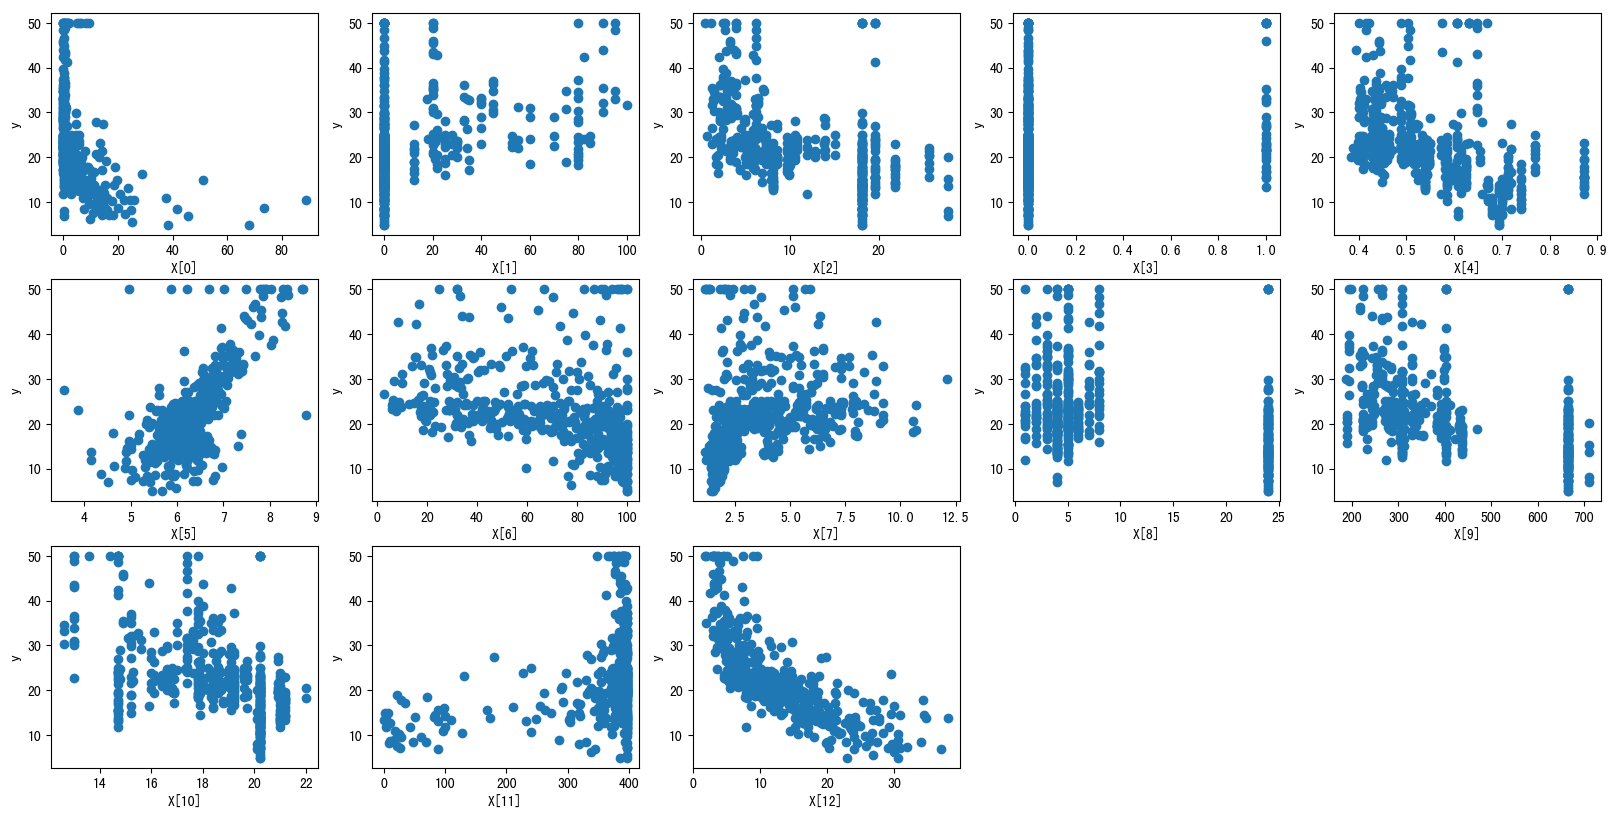

In [40]:
plot_figure(X, y)

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
# 对数据拆分，同时这个函数还会打乱数据顺序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [43]:
X_train.shape

(354, 13)

### 定义loss函数
 $公式一： loss_1= {1\over n} \sum_{i=1}^n |y_i - \hat{y_i}| $ $$$$
 $公式二： loss_2= {1\over n} \sum_{i=1}^n (y_i - \hat{y_i})^2 $

In [44]:
def loss_1(y, y_hat):
    return sum(abs(y_i - y_hat_i) for y_i, y_hat_i in zip(list(y), list(y_hat))) / len(list(y))

In [45]:
def loss_2(y, y_hat):
    return sum((y_i - y_hat_i)**2 for y_i, y_hat_i in zip(list(y), list(y_hat))) / len(list(y))

## First-Method: Random generation: get best k and best b

In [46]:
import random

In [47]:
X_rm = X_train[:, 5]
rand_range = 100
k = random.randint(-rand_range, rand_range)
b = random.randint(-rand_range, rand_range)

In [48]:
y_rm = k * X_rm + b

In [49]:
loss1 = loss_1(y_rm, y_train)
loss2 = loss_2(y_rm, y_train)
print('loss_1: {}'.format(loss1))
print('loss_2: {}'.format(loss2))

loss_1: 514.6906497175142
loss_2: 266838.3711223164


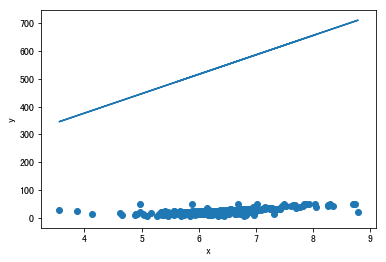

In [64]:
plt.plot(X_rm, y_rm)
plt.scatter(X_rm, y_train)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

nums:0, loss:97.92
nums:3, loss:12.03
nums:31, loss:7.63
nums:59, loss:6.45
nums:215, loss:4.83
nums:383, loss:4.55
The best k is 9, the best b is -76


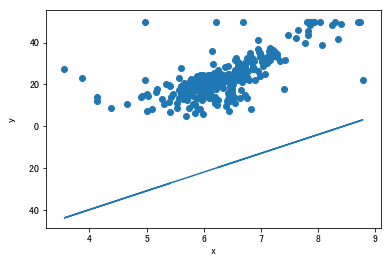

In [89]:
nums = 0
k, b = 0, 0
min_loss = 999999
while nums < 2000:
    k = random.randint(-rand_range, rand_range)
    b = random.randint(-rand_range, rand_range)
    y_rm = k * X_rm + b
    loss1 = loss_1(y_rm, y_train)
    if loss1 < min_loss:
        min_loss = loss1
        print('nums:{}, loss:{:.2f}'.format(nums, loss1))
    nums += 1
print('The best k is {}, the best b is {}'.format(k, b))
plt.plot(X_rm, y_rm)
plt.scatter(X_rm, y_train)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 小结：

    随机生成k、b的方式犹如大海捞针，随着次数越来越多可能会得到一个相对较优的结果，尽管如此，loss依然很大。

## Second-Method: Supervised Direction to get optimal k and b

The best k is 16, the best b is -78. min_loss is 5.7170


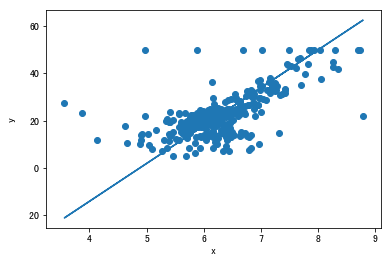

In [65]:
nums = 0
best_k = random.randint(-rand_range, rand_range)
best_b = random.randint(-rand_range, rand_range)
min_loss = 999999
direction = [(0,1),(0,-1),(1,0),(-1,0)]
weight = 1
while nums < 1000:
    for (d_k, d_b) in direction:
        k = best_k + d_k * weight
        b = best_b + d_b * weight
        y_sd = k * X_rm + b
        loss1 = loss_1(y_sd, y_train)
        if loss1 < min_loss:
            best_k = k
            best_b = b
            min_loss = loss1
#     print('nums:{}, loss:{:.2f}'.format(nums, loss1))
    nums += 1
y_sd = best_k * X_rm + best_b
print('The best k is {}, the best b is {}. min_loss is {:.4f}'.format(best_k, best_b, min_loss))
plt.plot(X_rm, y_sd)
plt.scatter(X_rm, y_train)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 小结：

    在初始化随机生成k、b后，让 k 和 b 朝着loss减小的方向变化这样比第一种方法更好，通过迭代能快速到达最优值。

## Third-Method: Gradient Descent to get optimal k and b

#### For Loss1:
$\frac{\partial}{\partial k}J(k,b)={1\over n} \sum_{i=1}^n |x_i| $ $$$$
$\frac{\partial}{\partial b}J(k,b)=1 $ $$$$
#### For Loss2:
$\frac{\partial}{\partial k}J(k,b)={1\over n} \sum_{i=1}^n (x_i (k x_i + b -y_i)) $ $$$$
$\frac{\partial}{\partial b}J(k,b)={1\over n} \sum_{i=1}^n (k x_i + b -y_i) $ $$$$
#### Iteration process:
$k:=k-\alpha\frac{\partial}{\partial k}J(k,b)$ $$$$
$b:=b-\alpha\frac{\partial}{\partial b}J(k,b)$

In [74]:
# 根据loss1求偏导数
def gradient_loss1_fun(x, y, k, b):
    partial_k = sum(abs(x_i) for x_i, y_i in zip(list(x), list(y))) / len(list(y))
    partial_b = 1
    return partial_k, partial_b 

# 根据loss2求偏导数
def gradient_loss2_fun(x, y, k, b):
    partial_k = sum(x_i * (x_i * k + b - y_i) for x_i, y_i in zip(list(x), list(y))) / len(list(y))
    partial_b = sum((x_i * k + b - y_i) for x_i, y_i in zip(list(x), list(y))) / len(list(y))
    return partial_k, partial_b
    
# 梯度下降
def gradient_descent(x, y, k, b, LR, fun=gradient_loss2_fun):
    partial_k, partial_b = fun(x, y, k, b)
    return k - LR * partial_k, b - LR * partial_b

nums:0, k:9.682760362231638, b:9.94967324858757, loss:2213.98
nums:100, k:2.3887817185739006, b:8.754062315700825, loss:75.27
nums:200, k:2.285954513468404, b:8.68797211257799, loss:77.37
nums:300, k:2.2919283346168386, b:8.63903121439211, loss:77.43
nums:400, k:2.2995392780879347, b:8.590408121288135, loss:77.45
nums:500, k:2.307165844813903, b:8.541848082833303, loss:77.47
nums:600, k:2.3147835108211585, b:8.493347173515266, loss:77.49
nums:700, k:2.3223919161491233, b:8.444905263170615, loss:77.51
nums:800, k:2.3299910664523544, b:8.396522279149888, loss:77.53
nums:900, k:2.3375809729040724, b:8.348198149759863, loss:77.55


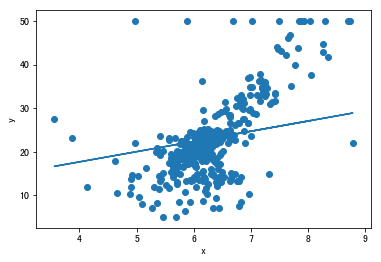

In [87]:
LR = 0.001
# 初始话参数 k，b
k = b = 10
# 迭代次数
nums = 0
while nums < 1000:
    k, b = gradient_descent(X_rm, y_train, k, b, LR)
    y_sd = k * X_rm + b
    loss2 = loss_2(y_sd, y)
    if nums % 100 == 0:
        print('nums:{}, k:{}, b:{}, loss:{:.2f}'.format(nums, k, b, loss2))
    nums += 1
y_sd = k * X_rm + b
plt.plot(X_rm, y_sd)
plt.scatter(X_rm, y_train)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Fourth-Method: Try different Loss function and learning rate

### a. Different learning rate and loss2

LR=0.001, k=2.2947439518576886, b=8.714814362144006
LR=0.01, k=2.382857805251719, b=8.059925360279415
LR=0.0485, k=4.686631803922449, b=5.6811924489903785
LR=0.0486, k=6.306337710425754, b=5.928715423623791


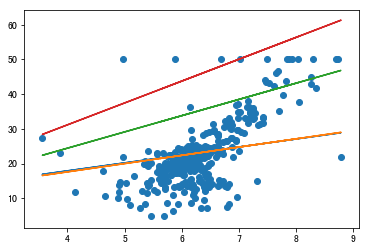

In [92]:
LR = [0.001, 0.01, 0.0485, 0.0486]
for lr in LR:
    # 初始话参数 k，b
    k = b = 10
    # 迭代次数
    nums = 0
    while nums < 150:
        k, b = gradient_descent(X_rm, y_train, k, b, lr)
        y_sd = k * X_rm + b
        loss2 = loss_2(y_sd, y)
        nums += 1
    y_sd = k * X_rm + b
    print('LR={}, k={}, b={}'.format(lr, k, b))
    plt.plot(X_rm, y_sd)
plt.scatter(X_rm, y_train)
plt.show()

### b. Different loss and learning rate is 0.001

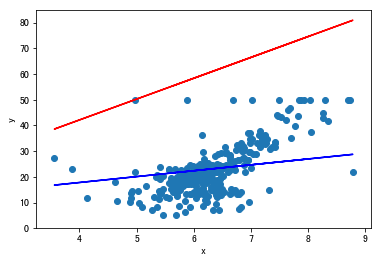

In [78]:
fun_list = [gradient_loss1_fun, gradient_loss2_fun]
fun_color = ['r', 'b']
for i in range(len(fun_list)):
    LR = 0.001
    # 初始话参数 k，b
    k = b = 10
    # 迭代次数
    nums = 0
    while nums < 300:
        k, b = gradient_descent(X_rm, y_train, k, b, LR, fun_list[i])
        y_sd = k * X_rm + b
        nums += 1
    y_sd = k * X_rm + b
    plt.plot(X_rm, y_sd, fun_color[i])

plt.scatter(X_rm, y_train)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


#### 小结：

    学习率会影响梯度下降的速度，也并不是学习率越大就越好，太大可能会越过所求的loss最低位置，所以可以在一开始的时候使用较大的学习率，快到达最低时在使用较小的学习率。对于loss函数的选择从上面不能明确看出，达到的效果相近。

## 2. Answer following questions
    
    2.1 Why do we need machine learning methods instead of creating a complicated formula?
    Ans: Because we can't get a complex formula to fit the data directly.

    2.2 What's the disadvantages of the 1st Random Choosen methods in our course?
    Ans: This method is very inefficient and can not obtain the optimal solution.

    2.3 Is the 2nd method supervised direction better than 1st one? What's the disadvantages of the 2nd supversied directin method?
    Ans: This method is slightly better than the first. But this method is influenced by the initial value of parameters.

    2.4 Why do we use Derivative / Gredient to fit a target function?
    Ans: Because Derivative or Gredient reflects the rate of change of the function.

    2.5 In the words 'Gredient Descent', what's the Gredient and what's the Descent?
    Ans: The Gredient is the derivative of a function at some point. The descent is the direction along which the gradient decreases.
    
    2.6 What's the advantages of the 3rd gradient descent method compared to the previous methods?
    Ans: This method can get the optimal solution quickly.

    2.7 Using the simple words to describe: What's the machine leanring.
    Ans: Machine learning is a complicated function that represents the relationship between input data and output data.